In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models
import wfdb
import random

### Load Data

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = "/Users/danielkim/Documents/MIDS/W207-ML/Final/Data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sampling_rate = 100

Y = pd.read_csv(path + "ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(lambda x: x[0] if len(x) > 0 else 'NORM')

In [4]:
X[0] # First example

array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
       [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
       [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
       ...,
       [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
       [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
       [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]])

In [5]:
y = Y['diagnostic_superclass'].to_numpy()
classes, counts = np.unique(y, return_counts=True)
classes, counts # Don't end up with same counts each time - fix?

(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object),
 array([4898, 1862, 2532, 9508, 2999]))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [7]:
y_train.shape

(17439,)

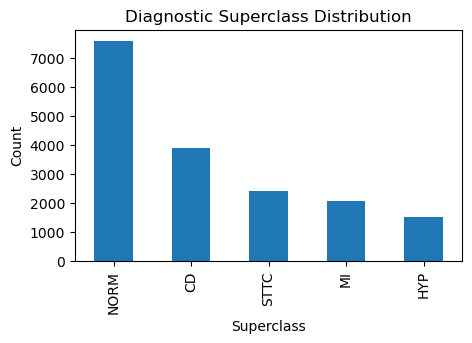

In [8]:
plt.figure(figsize=(5,3))
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

In [9]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
print(train_classes, train_counts)

['CD' 'HYP' 'MI' 'NORM' 'STTC'] [3885 1505 2055 7582 2412]


### Correct Data Imbalance

In [10]:
#smallest_class_count = min(train_counts)
#print(smallest_class_count)

In [11]:
#def get_class_subset(ekg_class):
#    y_train_class_indices = np.where(y_train == ekg_class)[0]
#    y_train_class_subset_indices = np.random.choice(
#        y_train_class_indices,
#        size=smallest_class_count,
#        replace=False
#    )
#    X_train_class_subset = X_train[y_train_class_subset_indices]
#    y_train_class_subset = np.array([ekg_class] * smallest_class_count)
#    return X_train_class_subset, y_train_class_subset

#X_train_cd, y_train_cd = get_class_subset('CD')
#X_train_hyp, y_train_hyp = get_class_subset('HYP')
#X_train_mi, y_train_mi = get_class_subset('MI')
#X_train_norm, y_train_norm = get_class_subset('NORM')
#X_train_sttc, y_train_sttc = get_class_subset('STTC')

In [12]:
#print(X_train_cd.shape)
#print(X_train_hyp.shape)
#print(X_train_mi.shape)
#print(X_train_norm.shape)
#print(X_train_sttc.shape)

In [13]:
#X_train = np.concatenate((X_train_cd, X_train_hyp, X_train_mi, X_train_norm, X_train_sttc))
#X_train.shape

In [14]:
#print(y_train_cd.shape)
#print(y_train_hyp.shape)
#print(y_train_mi.shape)
#print(y_train_norm.shape)
#print(y_train_sttc.shape)

In [15]:
#y_train = np.concatenate((y_train_cd, y_train_hyp, y_train_mi, y_train_norm, y_train_sttc))
#y_train.shape

In [16]:
#plt.figure(figsize=(5,3))
#pd.Series(y_train).value_counts().plot(kind='bar')
#plt.title('Diagnostic Superclass Distribution')
#plt.xlabel('Superclass')
#plt.ylabel('Count')
#plt.show()

### Split Data

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)

In [18]:
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (13951, 1000, 12)
Training labels shape: (13951,) 

Validation data shape: (3488, 1000, 12)
Validation labels shape: (3488,) 

Test data shape: (4360, 1000, 12)
Test labels shape: (4360,)


### Normalize Data

In [19]:
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-20.032 17.212


In [20]:
def normalize(data):
    data_mean = data.mean()
    data_sd = data.std()
    return (data - data_mean) / data_sd

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [21]:
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-84.6615727926282 72.74981945746957


### Baseline Models

Training accuracy: 0.2022077270446563
Validation accuracy: 0.19208715596330275
Test accuracy: 0.19036697247706422


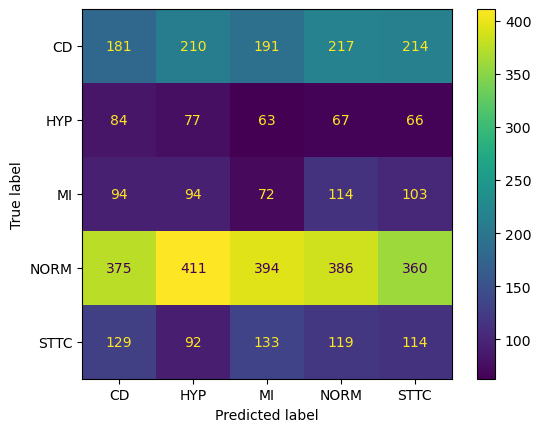

In [22]:
def random_classification(training_data):
    return [np.random.choice(classes) for _ in training_data]

predictions_train = random_classification(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = random_classification(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = random_classification(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

random_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=random_cm, display_labels=train_classes).plot();

Training accuracy: 0.4328721955415382
Validation accuracy: 0.4423738532110092
Test accuracy: 0.44174311926605503


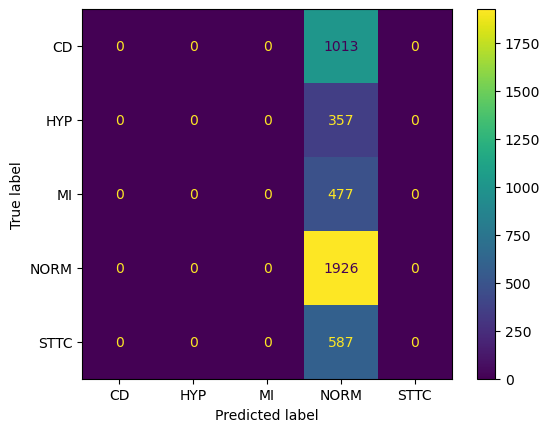

In [23]:
def always_classify_normal(training_data):
    return ['NORM'] * len(training_data)

predictions_train = always_classify_normal(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = always_classify_normal(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = always_classify_normal(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

normal_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=normal_cm, display_labels=train_classes).plot();

### Train Models

In [26]:
X_train_flattened = np.array([ekg.flatten() for ekg in X_train])
print(X_train_flattened.shape)

X_val_flattened = np.array([ekg.flatten() for ekg in X_val])
print(X_val_flattened.shape)

X_test_flattened = np.array([ekg.flatten() for ekg in X_test])
print(X_test_flattened.shape)

(13951, 12000)
(3488, 12000)
(4360, 12000)


**Neural Network**

In [27]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)

In [29]:
training_accuracies = []
validation_accuracies = []

for i in range(30):

    seed = np.random.randint(1, 999999)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    
    model = models.Sequential()
    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(1000, 12)))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(12, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_val, y_val))

    training_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

print(f"Training accuracies: {training_accuracies}")
print(f"Validation accuracies: {validation_accuracies}")

Epoch 1/10
436/436 [==============================] - 15s 33ms/step - loss: 0.5619 - accuracy: 0.1790 - val_loss: 0.4372 - val_accuracy: 0.4481
Epoch 2/10
436/436 [==============================] - 15s 35ms/step - loss: 0.4624 - accuracy: 0.4630 - val_loss: 0.3964 - val_accuracy: 0.6451
Epoch 3/10
436/436 [==============================] - 14s 32ms/step - loss: 0.4314 - accuracy: 0.5706 - val_loss: 0.3826 - val_accuracy: 0.6732
Epoch 4/10
436/436 [==============================] - 14s 33ms/step - loss: 0.4093 - accuracy: 0.6112 - val_loss: 0.3804 - val_accuracy: 0.6743
Epoch 5/10
436/436 [==============================] - 14s 32ms/step - loss: 0.3944 - accuracy: 0.6209 - val_loss: 0.3797 - val_accuracy: 0.6763
Epoch 6/10
436/436 [==============================] - 14s 32ms/step - loss: 0.3863 - accuracy: 0.6403 - val_loss: 0.3747 - val_accuracy: 0.6775
Epoch 7/10
436/436 [==============================] - 14s 32ms/step - loss: 0.3700 - accuracy: 0.6592 - val_loss: 0.3601 - val_accuracy:

In [35]:
training_accuracies = np.array(training_accuracies)
validation_accuracies = np.array(validation_accuracies)

In [36]:
training_acc = training_accuracies[:, -1]
validation_acc = validation_accuracies[:, -1]

In [46]:
accuracy = np.stack((training_acc, validation_acc), axis =1)
accuracy = pd.DataFrame(accuracy)

Text(0, 0.5, 'Validation Accuracy')

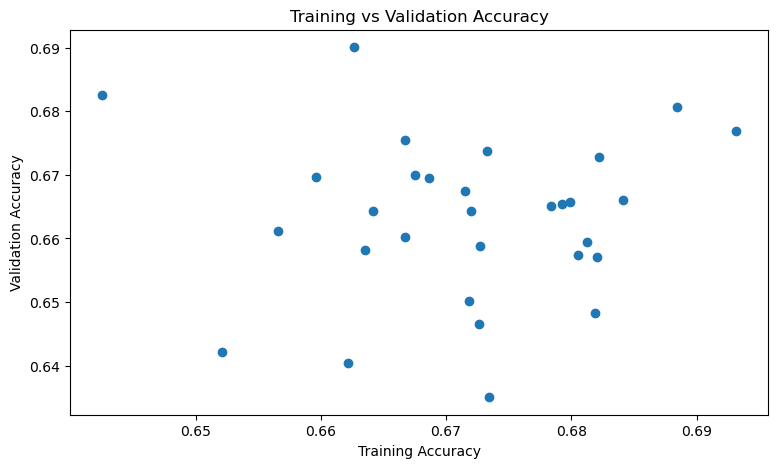

In [51]:
plt.figure(figsize=(9, 5))
plt.scatter(training_acc, validation_acc)

plt.title('Training vs Validation Accuracy')
plt.xlabel('Training Accuracy')
plt.ylabel('Validation Accuracy')

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Accross Epochs')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show();